## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from datetime import datetime

# 1. Data Preparation

## Import Dataset and Combine Dataframe

In [2]:
# Import data
dir_path = 'D:\OneDrive - Chalmers\Git\een210_applied_digital_health\data\data_labeled'
files = glob.glob(os.path.join(dir_path , '*.csv'))

dataset_all = []

# Columns to read from each file
columns_to_read = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 'timestamp', 'label']

# Loop append each file
for file_path in files:
    df = pd.read_csv(file_path, index_col=None, header=0, usecols=columns_to_read)
    df['filename'] = os.path.splitext(os.path.basename(file_path))[0]
    dataset_all.append(df)
    print(os.path.splitext(os.path.basename(file_path))[0])

# Concatenate all data
dataset_all = pd.concat(dataset_all, axis=0, ignore_index=True)

fall_back_data_20240129_163134_labeled
fall_back_mew_data_20240129_165424_labeled
fall_front_data_20240129_163754_labeled
fall_front_mew_data_20240129_170336_labeled
fall_sideLeft_data_20240129_164741_labeled
fall_sideRight_data_20240129_164251_labeled
stairs_down_data_20240124_150347_labeled
stairs_down_data_20240124_152206_labeled
stairs_down_data_20240124_152408_labeled
stairs_down_data_20240124_152621_labeled
stairs_up_data_20240124_152108_labeled
stairs_up_data_20240124_152306_labeled
stairs_up_data_20240124_152516_labeled
standing_data_20240124_143101_labeled
standing_data_20240124_143514_labeled
standing_data_20240124_143747_labeled
walking_data_20240124_142045_labeled
walking_data_20240124_142333_labeled
walking_data_20240124_142757_labeled


## Investigate Sampling Time

In [3]:
# Try to parse using the most specific format.
dataset_all['timestamp_dt'] = pd.to_datetime(
        dataset_all['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce'
    )
    
#Fill the NaT values by trying the less specific format.
dataset_all['timestamp_dt'] = dataset_all['timestamp_dt'].fillna(
    pd.to_datetime(dataset_all['timestamp'], format='%Y-%m-%d %H:%M', errors='coerce')
)

# Use the newly created datetime column for calculations
timestamp_col = 'timestamp_dt'

# Calculate sampling time per filename 
grouped_data = dataset_all.groupby('filename')
sampling_stats = []

for filename, group in grouped_data:
    # Sort the timestamps just in case they're not in order within the file
    group = group.sort_values(by=timestamp_col)
    
    file_time_diffs = group[timestamp_col].diff().dropna()
    
    if not file_time_diffs.empty:
        mean_time_diff = file_time_diffs.mean()
        mean_time_diff_seconds = mean_time_diff.total_seconds()
        
        if mean_time_diff_seconds > 0:
            sampling_rate = 1 / mean_time_diff_seconds
        else:
            sampling_rate = np.inf if len(group) > 1 else np.nan
        
        sampling_stats.append({
            'filename': filename,
            'avg_samp_time_s': np.round(mean_time_diff_seconds,3),
            'avg_samp_rate_hz': np.round(sampling_rate,1)
        })
    else:
        sampling_stats.append({
            'filename': filename,
            'avg_sampling_time_s': np.nan,
            'avg_sampling_rate_hz': np.nan
        })

sampling_stats_df = pd.DataFrame(sampling_stats)
sampling_stats_df.head()

filename  avg_samp_time_s  \
0       fall_back_data_20240129_163134_labeled            0.071   
1   fall_back_mew_data_20240129_165424_labeled            0.064   
2      fall_front_data_20240129_163754_labeled            0.058   
3  fall_front_mew_data_20240129_170336_labeled            0.061   
4   fall_sideLeft_data_20240129_164741_labeled            0.058   

   avg_samp_rate_hz  
0              14.0  
1              15.6  
2              17.2  
3              16.4  
4              17.4

## Visualize Signal - Romove Baseline & Smoothing

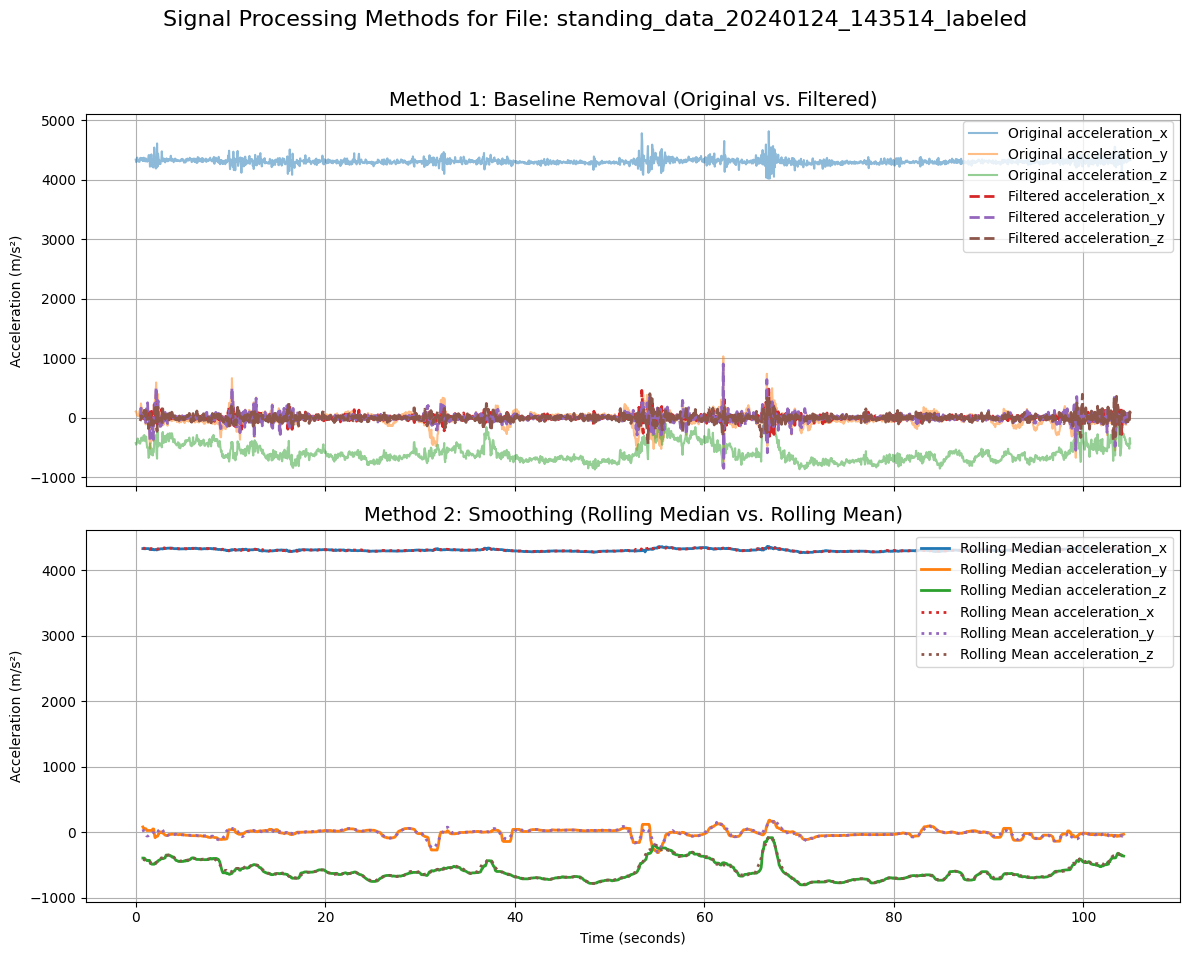

In [4]:
def rm_baseline(sig, nwin):    
    N = len(sig)
    idx = int((nwin-1)/2)

    sig = sig.values
    sig_norm = np.zeros(N)*np.nan
    
    # Remove baseline with mean
    for i in np.arange(N-idx):
        sig_win = sig[i:(i+nwin)]
        sig_mean = np.mean(sig_win)
        sig_norm[i+idx] = sig[i+idx]-sig_mean

    return sig_norm

# 1. Data Selection and Initialization
filename = 'standing_data_20240124_143514_labeled'
temp = dataset_all.loc[dataset_all['filename'] == filename, :]

# Use a list for column names for cleaner indexing
cols = ['acceleration_x', 'acceleration_y', 'acceleration_z']
sig = temp[cols]

# Define constants
fs = 20  # Sampling frequency
nwin = 30  # Window size for filtering (around 1.5 seconds)
npnts = len(sig)
timevec = np.arange(npnts) / fs

# Create a figure and axes for plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)
fig.suptitle(f'Signal Processing Methods for File: {filename}', fontsize=16)

# --- Method 1: Baseline Removal (e.g., subtracting a rolling mean) ---
# Apply the baseline removal
sig_rm = sig[cols].apply(lambda x: rm_baseline(x, fs))

# Plot the original and filtered signals for comparison
axes[0].set_title('Method 1: Baseline Removal (Original vs. Filtered)', fontsize=14)
axes[0].plot(timevec, sig, alpha=0.5)
axes[0].plot(timevec, sig_rm, linestyle='--', linewidth=2)
axes[0].legend([f'Original {c}' for c in cols] + [f'Filtered {c}' for c in cols],
               loc='upper right')
axes[0].set_ylabel('Acceleration (m/s²)')
axes[0].grid(True)

# --- Method 2: Smoothing (e.g., a rolling median) ---
# Apply a rolling median to the signal
sig_median = sig.rolling(window=nwin, center=True).median()
sig_mean = sig.rolling(window=nwin, center=True).mean()

axes[1].set_title('Method 2: Smoothing (Rolling Median vs. Rolling Mean)', fontsize=14)
axes[1].plot(timevec, sig_median, linewidth=2, linestyle='-')
axes[1].plot(timevec, sig_mean, linewidth=2, linestyle=':')
axes[1].legend([f'Rolling Median {c}' for c in cols] + [f'Rolling Mean {c}' for c in cols],
               loc='upper right')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Acceleration (m/s²)')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for suptitle
plt.show()

## Visualize Signal in Frequncy Domain

d:\OneDrive - Chalmers\Git\een210_applied_digital_health\.venv\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


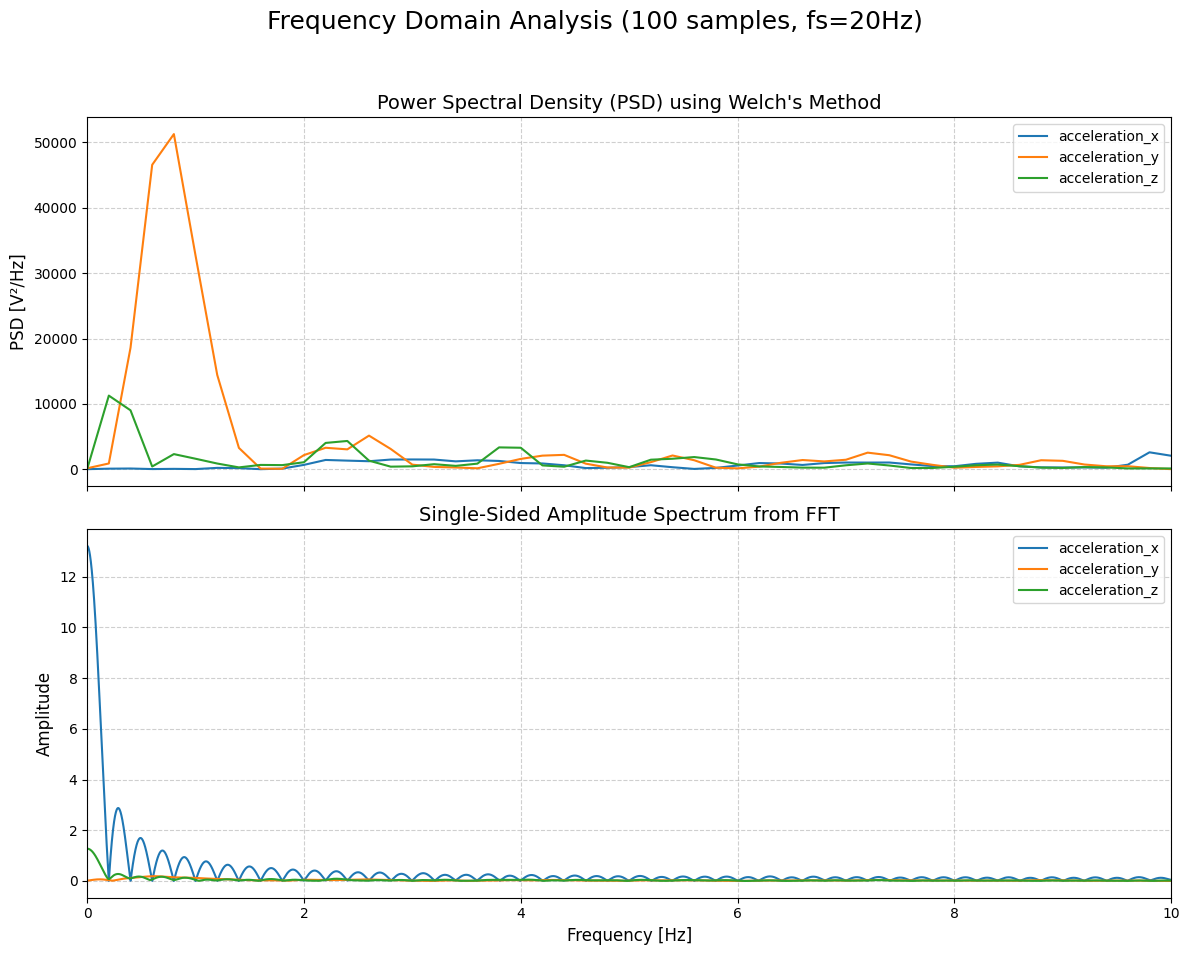

In [5]:
import scipy
from scipy import signal
from scipy.fftpack import fft

def get_psd(df, fs, window="hann"):
    f_psd, df_psd = signal.welch(df, fs, window=window)
    # df_psd = pd.DataFrame(psd, columns=df.columns)
    # df_psd["Frequency_Hz"] = f
    # df_psd = df_psd.set_index("Frequency_Hz")
    return f_psd, df_psd

# power spectrum of signal
def get_fft(df, fs):
    nfft = 2**16
    df_fft = fft(df, nfft)
    df_fft = 2*np.abs(df_fft[0:nfft//2]/nfft)
    f_fft = np.linspace(0,fs/2,int(np.floor(nfft/2)))
    return f_fft, df_fft


fs = 20  # Sampling frequency
nwin = 100  # Number of points to analyze

# Create a single figure with two subplots for comparison
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)
fig.suptitle(f"Frequency Domain Analysis ({nwin} samples, fs={fs}Hz)", fontsize=18)

# 1. Plotting Power Spectral Density (PSD) 
axes[0].set_title('Power Spectral Density (PSD) using Welch\'s Method', fontsize=14)
for c in cols:
    sig = temp[c].iloc[:nwin].values
    if len(sig) > 0: 
        f_values, psd_values = get_psd(sig, fs)
        axes[0].plot(f_values, psd_values, linestyle='-', label=c)

axes[0].set_ylabel('PSD [V²/Hz]', fontsize=12)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# 2. Plotting Fast Fourier Transform (FFT) 
axes[1].set_title('Single-Sided Amplitude Spectrum from FFT', fontsize=14)
for c in cols:
    sig = temp[c].iloc[:nwin].values
    if len(sig) > 0:
        f_values, fft_values = get_fft(sig, fs)
        axes[1].plot(f_values, fft_values, linestyle='-', label=c)

axes[1].set_xlabel('Frequency [Hz]', fontsize=12)
axes[1].set_ylabel('Amplitude', fontsize=12)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Set common x-axis limits for both plots
axes[0].set_xlim([0, fs / 2])
axes[1].set_xlim([0, fs / 2])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Zero Order Hold Interpolation

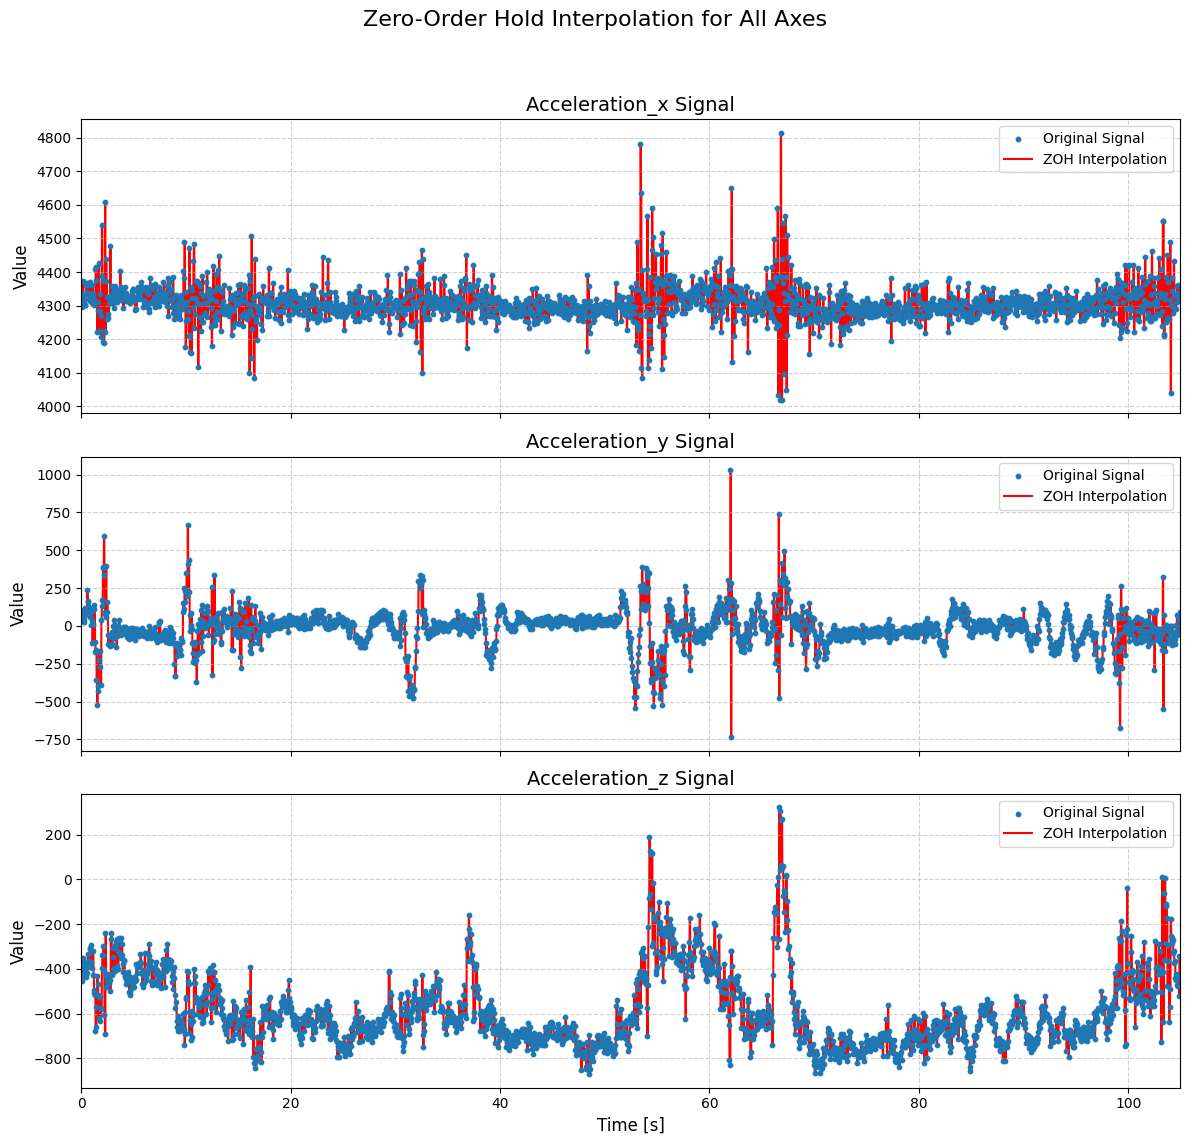

In [6]:
def interp0(x, xp, yp):
    """Zeroth order hold interpolation w/ same signature as numpy.interp."""

    def func(x0):
        if x0 <= xp[0]:
            return yp[0]        
        if x0 >= xp[-1]:
            return yp[-1]        
        k = 0
        while x0 > xp[k]:
            k += 1
        return yp[k-1]
    
    if isinstance(x,float):
        return func(x)
    elif isinstance(x, list):
        return [func(x) for x in x]
    elif isinstance(x, np.ndarray):
        return np.asarray([func(x) for x in x])
    else:
        raise TypeError('argument must be float, list, or ndarray')
    
fs = 20  # Sampling frequency
npnts = len(temp)

t = np.linspace(0, (npnts - 1) / fs, npnts)
t_intpl = np.linspace(t.min(), t.max(), 5 * npnts)

# plot ZOH 
fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(12, 4 * len(cols)), sharex=True)
fig.suptitle('Zero-Order Hold Interpolation for All Axes', fontsize=16)

for i, c in enumerate(cols):
    # Get the original signal for the current column
    sig = temp[c].values

    # Perform the ZOH interpolation for this specific column
    sig_intpl = interp0(t_intpl, t, sig)

    # Plot the original data as scatter points
    axes[i].scatter(t, sig, label='Original Signal', zorder=2, s=10)
    
    # Plot the interpolated data as a continuous line
    axes[i].plot(t_intpl, sig_intpl, 'r-', label='ZOH Interpolation', zorder=1)

    # Set titles and labels for the subplot
    axes[i].set_title(f'{c.capitalize()} Signal', fontsize=14)
    axes[i].set_ylabel('Value', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.6)

# Set common labels for the bottom subplot
axes[-1].set_xlabel('Time [s]', fontsize=12)
axes[-1].set_xlim([t_intpl.min(), t_intpl.max()])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



## Apply Low Pass Filter

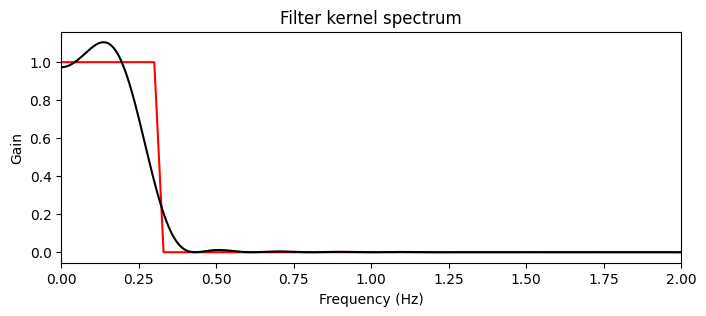

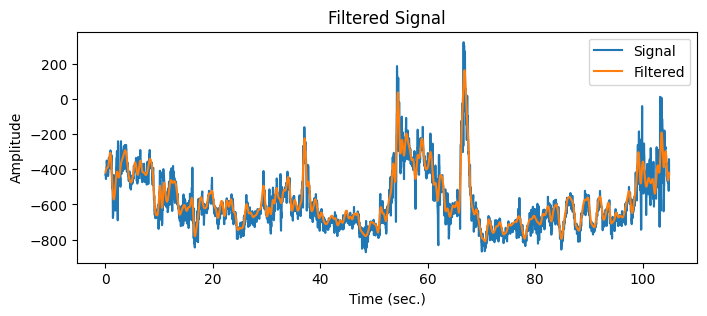

In [7]:
# Low pass filter
fs = 20
npnts = len(sig_intpl)

fcutoff = 0.3
transw  = 0.1
order   = np.round(1.5*fs/fcutoff )+1

shape   = [ 1,1,0,0 ]
frex    = [ 0, fcutoff, fcutoff+(fcutoff*transw), fs/2 ]

hz = np.linspace(0,fs/2,int(np.floor(npnts/2)+1))

# filter kernel
filtkern = signal.firls(order,frex,shape,fs=fs)

# its power spectrum
filtkernX = np.abs(scipy.fftpack.fft(filtkern,npnts))**2

plt.figure(figsize=(8,3))
plt.plot(np.array(frex),shape,'r')
plt.plot(hz,filtkernX[:len(hz)],'k')
plt.xlim([0,2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Filter kernel spectrum')
plt.show()

# plot the data
yFilt = signal.filtfilt(filtkern,1,sig_intpl)

plt.figure(figsize=(8,3))
plt.plot(t_intpl,sig_intpl,label='Signal')
plt.plot(t_intpl,yFilt,label='Filtered')
plt.legend()
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.title('Filtered Signal')
plt.show()

## Calculate Statistical Features

In [8]:
import pandas as pd
import numpy as np
import pickle

# --- Refactored Helper Functions ---

def rm_baseline_vectorized(series: pd.Series, nwin: int) -> pd.Series:
    x_mean = series.rolling(window=nwin, center=True).mean()
    return series - x_mean

def load_model_and_scaler(model_path: str):
    scaler_path = f'{model_path}/LR_scaler.pkl'
    model_file_path = f'{model_path}/LR_classifier_model.pkl'
    
    with open(scaler_path, 'rb') as sc_file:
        scaler = pickle.load(sc_file)
    with open(model_file_path, 'rb') as model_file:  
        model = pickle.load(model_file)
        
    return scaler, model

def apply_lr_model(
    series: pd.Series, 
    scaler, 
    classifier, 
    window_size: int
) -> np.ndarray:
    
    """
    Applies a pre-trained LR model and scaler to a time-series feature.
    This function replaces the redundant apply_LR_... functions.
    """
    series_filled = series.fillna(0).values
    
    windows = np.lib.stride_tricks.sliding_window_view(series_filled, window_size)
    windows_scaled = scaler.transform(windows)
    
    x_prob = classifier.predict_proba(windows_scaled)[:, 1]
    
    final_prob = np.full(len(series), np.nan)
    padding = (window_size - 1) // 2
    final_prob[padding:len(final_prob) - padding] = x_prob
    
    return final_prob

def calFeat_clean(df: pd.DataFrame, nwin_feat: int, nwin_baseline: int) -> pd.DataFrame:

    # All baseline removal is now vectorized
    feat_baseline_removed = df.apply(lambda col: rm_baseline_vectorized(col, nwin_baseline))
    
    # Calculate magnitudes (on baseline-removed data)
    feat_baseline_removed['acc_magnitude'] = np.sqrt(
        feat_baseline_removed['acceleration_x']**2 +
        feat_baseline_removed['acceleration_y']**2 +
        feat_baseline_removed['acceleration_z']**2
    )
    feat_baseline_removed['gyr_magnitude'] = np.sqrt(
        feat_baseline_removed['gyroscope_x']**2 +
        feat_baseline_removed['gyroscope_y']**2 +
        feat_baseline_removed['gyroscope_z']**2
    )
    
    # Calculate smoothing features
    feat_sm = df[['acceleration_x', 'acceleration_y', 'acceleration_z']].rolling(
        window=nwin_baseline, center=True
    ).agg("median")
    feat_sm.columns = [f"{col}_median" for col in feat_sm.columns]

    # Calculate statistical time domain features
    feat_stat = feat_baseline_removed.rolling(
        window=nwin_feat, center=True
    ).agg(["sum", "mean", "std", "min", "max"])
    feat_stat.columns = [f"{col[0]}_{col[1]}" for col in feat_stat.columns] # Bug Fix: Using feat_stat.columns
    
    # Rename baseline-removed columns for clarity
    feat_baseline_removed = feat_baseline_removed.rename(columns={
        c: f"{c}_rm" for c in feat_baseline_removed.columns if c in df.columns
    })
    
    return pd.concat([df, feat_sm, feat_baseline_removed, feat_stat], axis=1)


# 1. Define constants and variables
nwin_feat = 11
nwin_rm_baseline = 21 # 1 sec at 20 Hz
cols = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyroscope_x','gyroscope_y', 'gyroscope_z']

# 2. Load models once, outside the loop (major efficiency improvement)
sc_acc_x, model_acc_x = load_model_and_scaler('./model/LR_acceleration_x')
sc_acc_mag, model_acc_mag = load_model_and_scaler('./model/LR_acc_magnitude')

# 3. Use a list to collect results, then concatenate (major efficiency improvement)
all_feat_dfs = []
for fn in dataset_all['filename'].unique():
    # Get individual file data
    dataset = dataset_all.loc[dataset_all['filename']==fn, :].copy()
    
    # Feature extraction using the cleaner function
    feat = calFeat_clean(dataset[cols], nwin_feat, nwin_rm_baseline)
    
    # Apply models using the refactored, generic function
    feat['acceleration_x_LR'] = apply_lr_model(
        dataset['acceleration_x'], sc_acc_x, model_acc_x, 21
    )
    # Apply to the magnitude column calculated within calFeat_clean
    feat['acc_magnitude_LR'] = apply_lr_model(
        feat['acc_magnitude'], sc_acc_mag, model_acc_mag, 11
    )
    
    # Add metadata back to the feature DataFrame
    feat.loc[:, 'label'] = dataset.loc[:, 'label']
    feat.loc[:, 'filename'] = dataset.loc[:, 'filename']
    
    all_feat_dfs.append(feat)

# 4. Concatenate all feature DataFrames at once
dataset_feat = pd.concat(all_feat_dfs, ignore_index=True)

## Mapping Classes

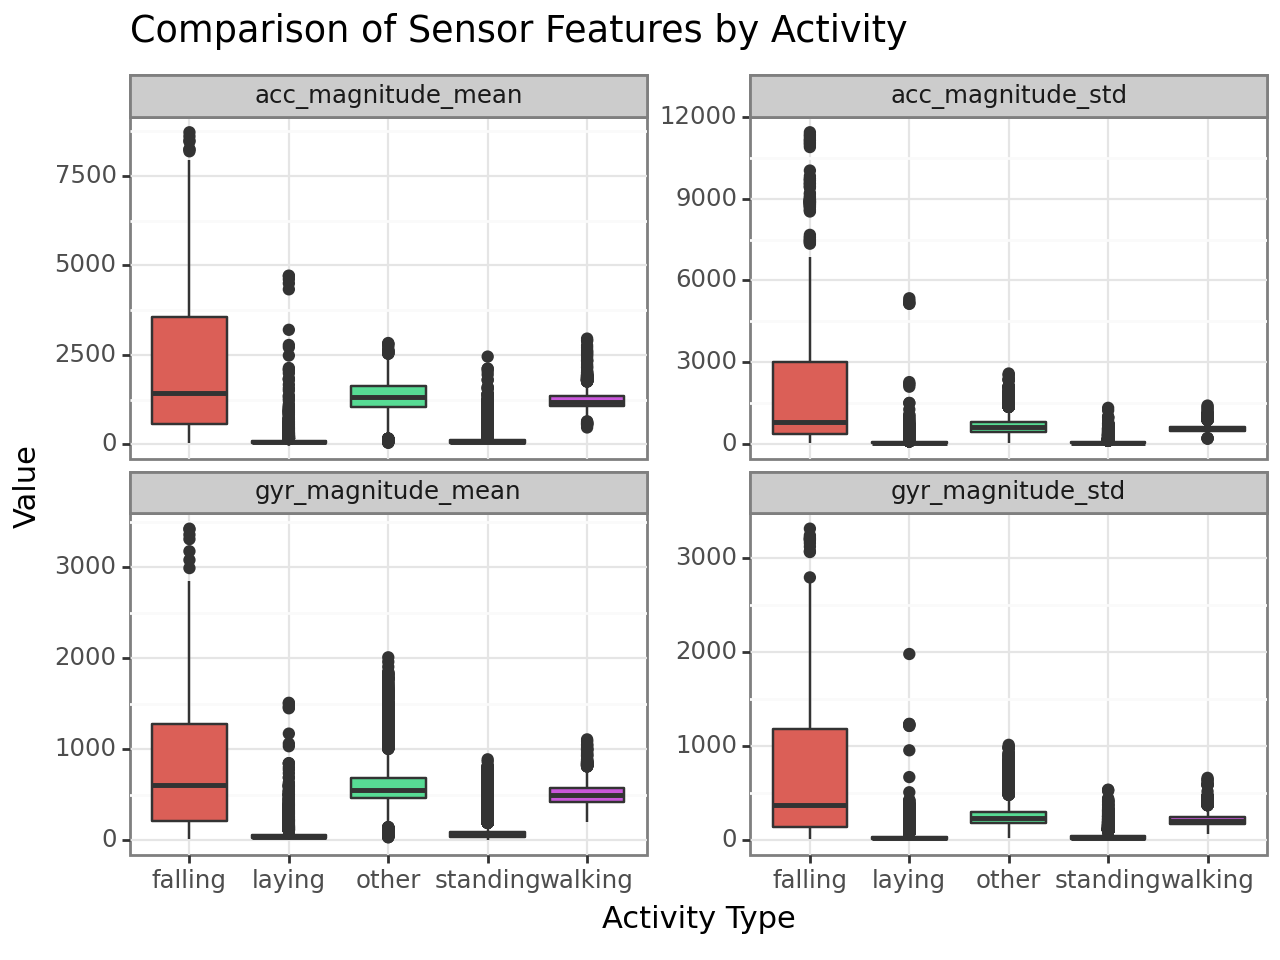

In [9]:
from plotnine import *

def map_label_to_new_category(label):
    if 'fall' in str(label):
        return 'falling'
    elif 'walking' in str(label):
        return 'walking'
    elif 'standing' in str(label):
        return 'standing'    
    elif 'laying' in str(label):
        return 'laying'    
    else:
        return 'other'

# Apply the function to create a new label column
dataset_feat['simple_label'] = dataset_feat['label'].apply(map_label_to_new_category)

# Reshape df
dataset_feat_long = pd.melt(dataset_feat, 
                            id_vars=['simple_label','label'],
                            value_vars=["acc_magnitude_mean","acc_magnitude_std", "gyr_magnitude_mean","gyr_magnitude_std"], 
                            var_name='feat', 
                            value_name='val')

dataset_feat_long = dataset_feat_long.dropna()

# Plot 
p = (
    ggplot(dataset_feat_long, aes(x='simple_label', y='val', fill='simple_label'))
    + geom_boxplot(show_legend=False)  
    + facet_wrap('~feat', scales='free_y') 
    + labs(
        title="Comparison of Sensor Features by Activity",
        x="Activity Type",
        y="Value",
        fill="Activity" 
    )
    + theme_bw() 
)
print(p)

## Train-Test Split & Normalizing

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop rows with any missing values to ensure a clean dataset
data = dataset_feat.dropna()

# Filter the dataset to include only specific activity labels for our classification task
data = data[data["simple_label"].isin(["falling", "walking", "standing", "laying"])]

# Separate the features (X) from the target variable (y)
X = data.drop(['label','simple_label','filename'], axis=1)
y = data['simple_label']

# Data Splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cols_feat = X_train.columns

# Standardize features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## Random Forest

In [11]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
classifier = RandomForestClassifier(n_estimators=10)

# Train the classifier on the training set
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Report
classification_report_str = classification_report(y_test, y_pred)
print(classification_report_str)

Accuracy: 0.9916500994035785
              precision    recall  f1-score   support

     falling       0.92      0.91      0.91       230
      laying       0.99      0.99      0.99       989
    standing       0.99      0.99      0.99      2311
     walking       1.00      1.00      1.00      1500

    accuracy                           0.99      5030
   macro avg       0.98      0.97      0.97      5030
weighted avg       0.99      0.99      0.99      5030



## Features Selection

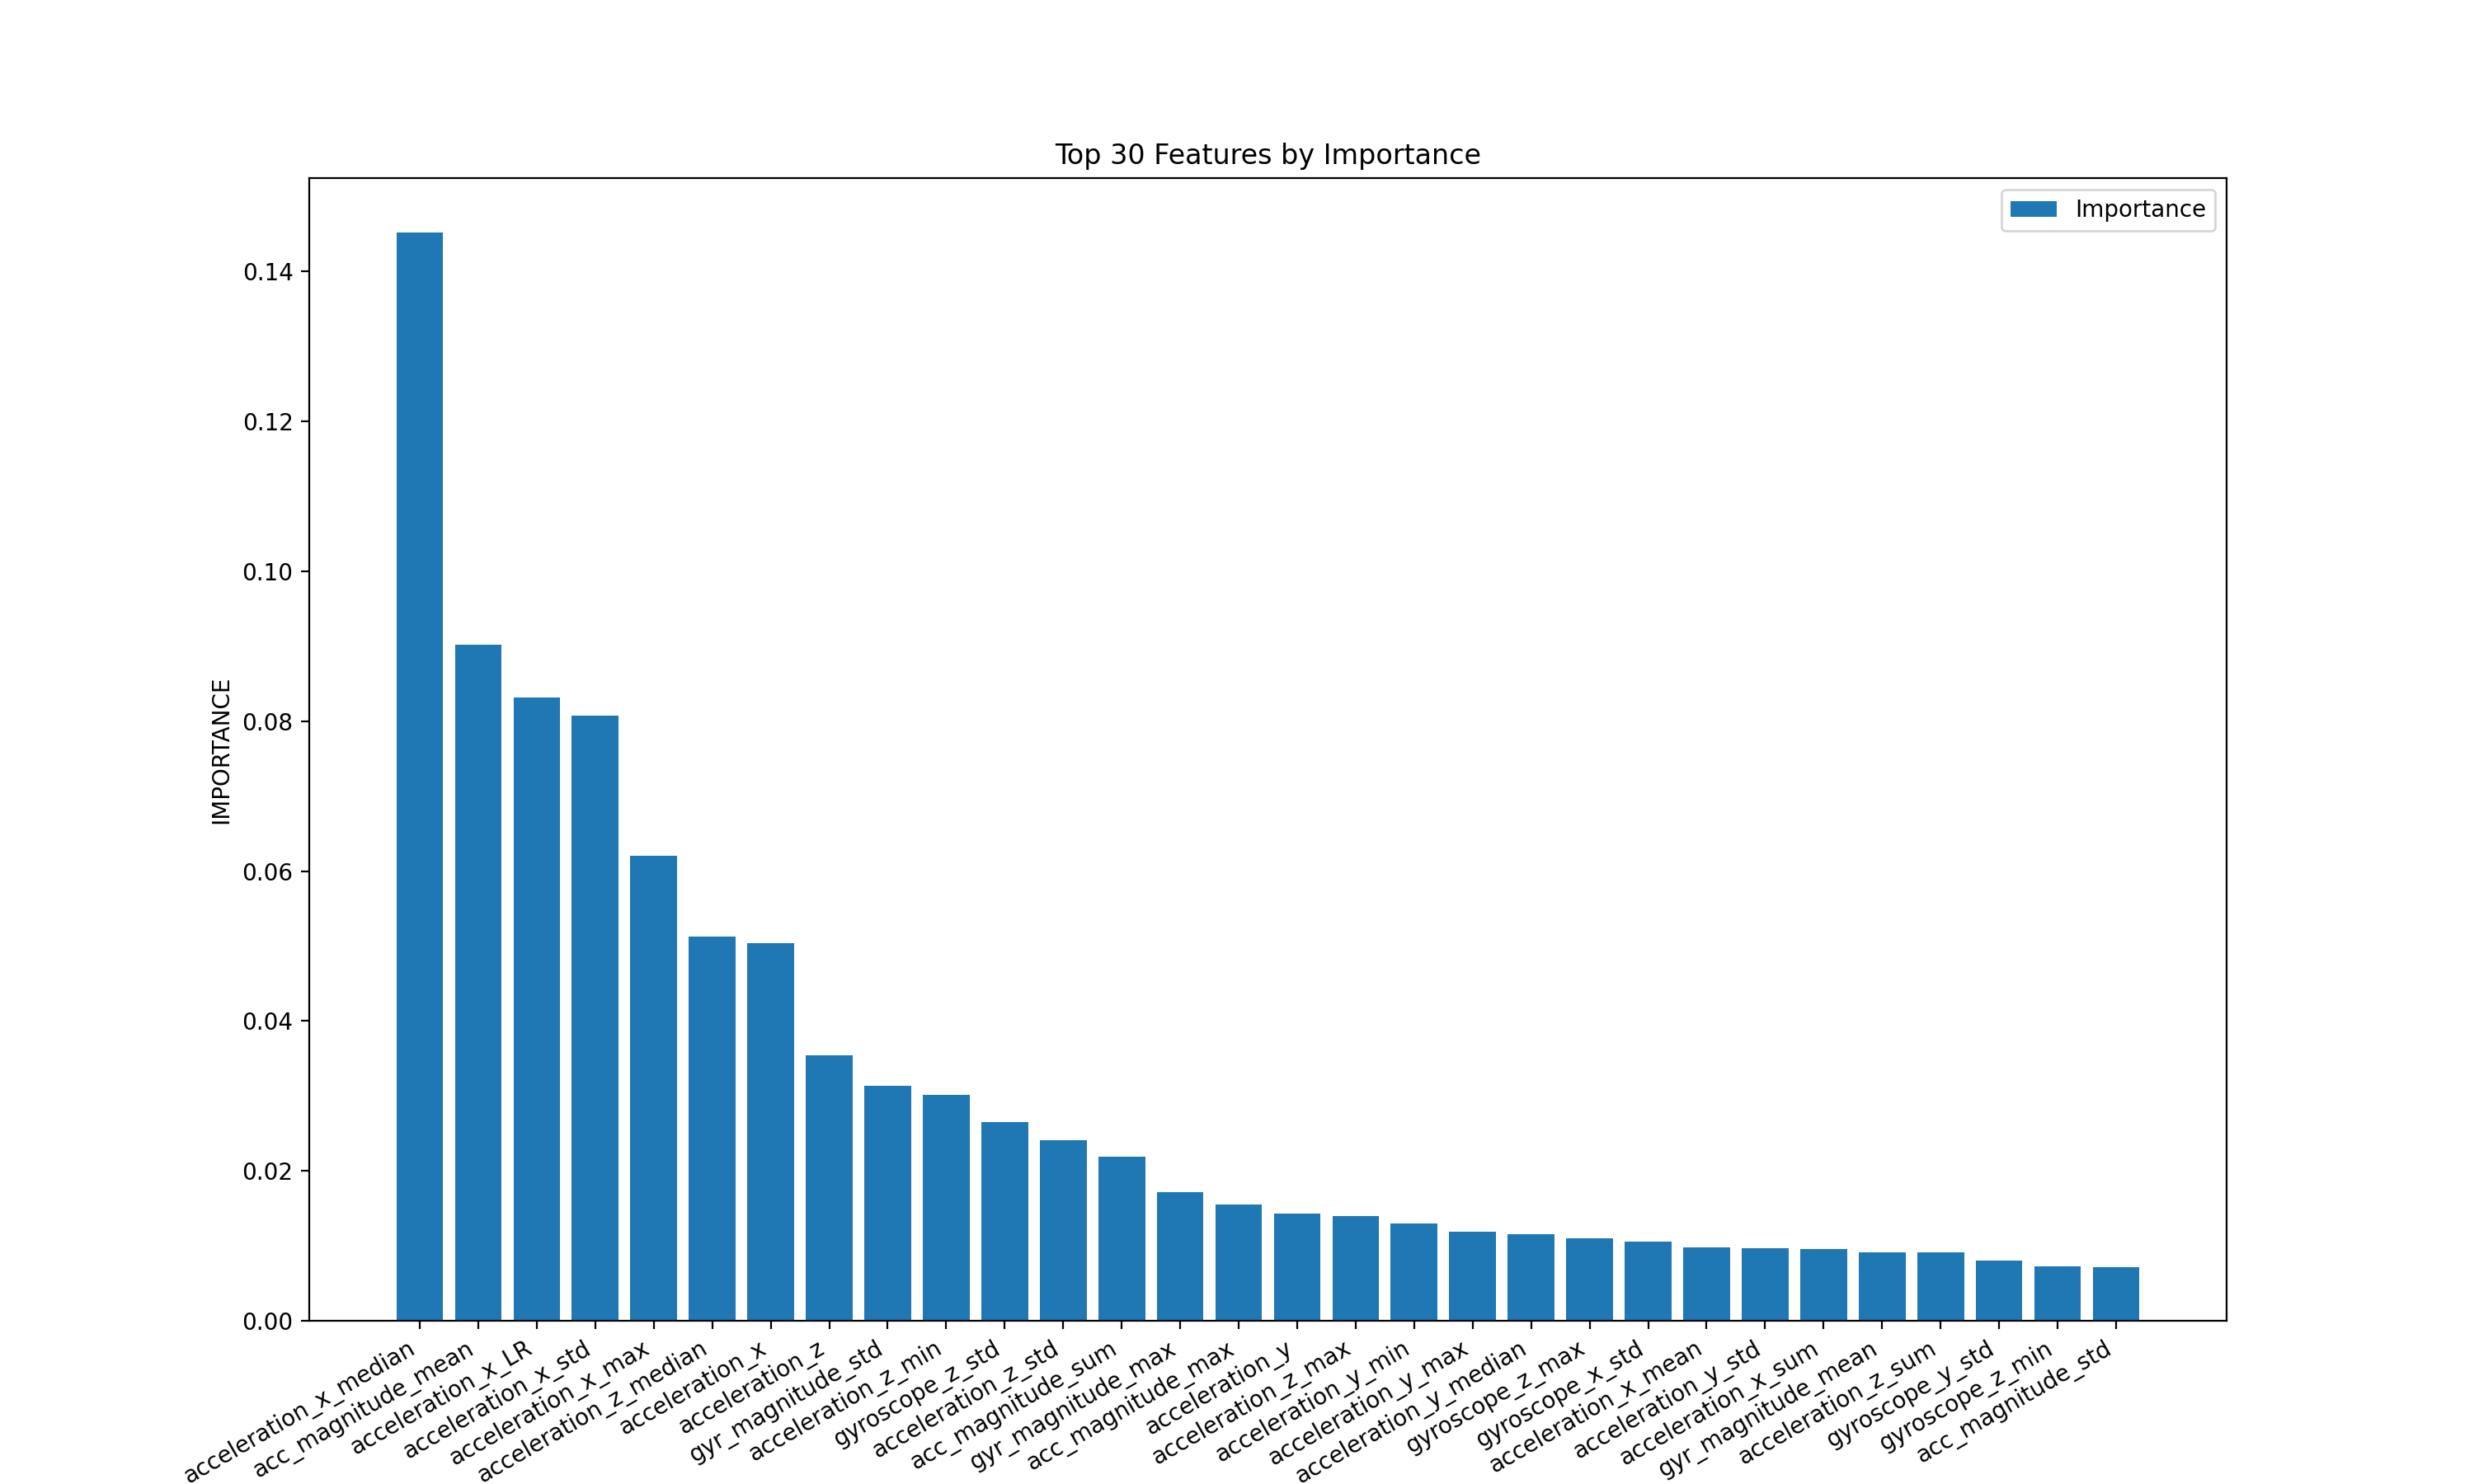

In [12]:
import operator
from sklearn.model_selection import  StratifiedKFold

# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=10, class_weight='balanced', criterion='gini', random_state=42) # Use gini criterion to define feature importance
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform cross-validation and calculate feature importance
list_feature_importance = []  

for train_index, test_index in k_fold.split(X, y):
    X_train = X.iloc[train_index,:]
    y_train = y.iloc[train_index]

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)

    # Train the classifier
    rfc.fit(X_train, y_train)
    importances = rfc.feature_importances_

    list_feature_importance.append(importances)

# Calculate average feature importance
avg_importance = np.mean(list_feature_importance, axis=0)

zipped = list(zip(X.columns, avg_importance))

sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
sorted_list1, sorted_list2 = zip(*sorted_zipped)


# create DataFrame using data
df_imp = pd.DataFrame(sorted_zipped, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head()

# Sort the DataFrame by 'IMPORTANT' in descending order
df_imp_sorted = df_imp.sort_values(by='IMPORTANCE', ascending=False)

# Calculate the cumulative sum of 'IMPORTANT'
df_imp_sorted['CUMULATIVE'] = df_imp_sorted['IMPORTANCE'].cumsum()

# Plot the bar chart for 'IMPORTANCE'
plt.figure(figsize=(15, 9))

plt.bar(df_imp_sorted['FEATURE'][:30], df_imp_sorted['IMPORTANCE'][:30], label='Importance')
plt.xlabel('FEATURE')
plt.ylabel('IMPORTANCE')

plt.xticks(rotation=30, ha='right')
plt.legend()
plt.title('Top 30 Features by Importance')
plt.show()

### Check Correlation - drop high correlation feature

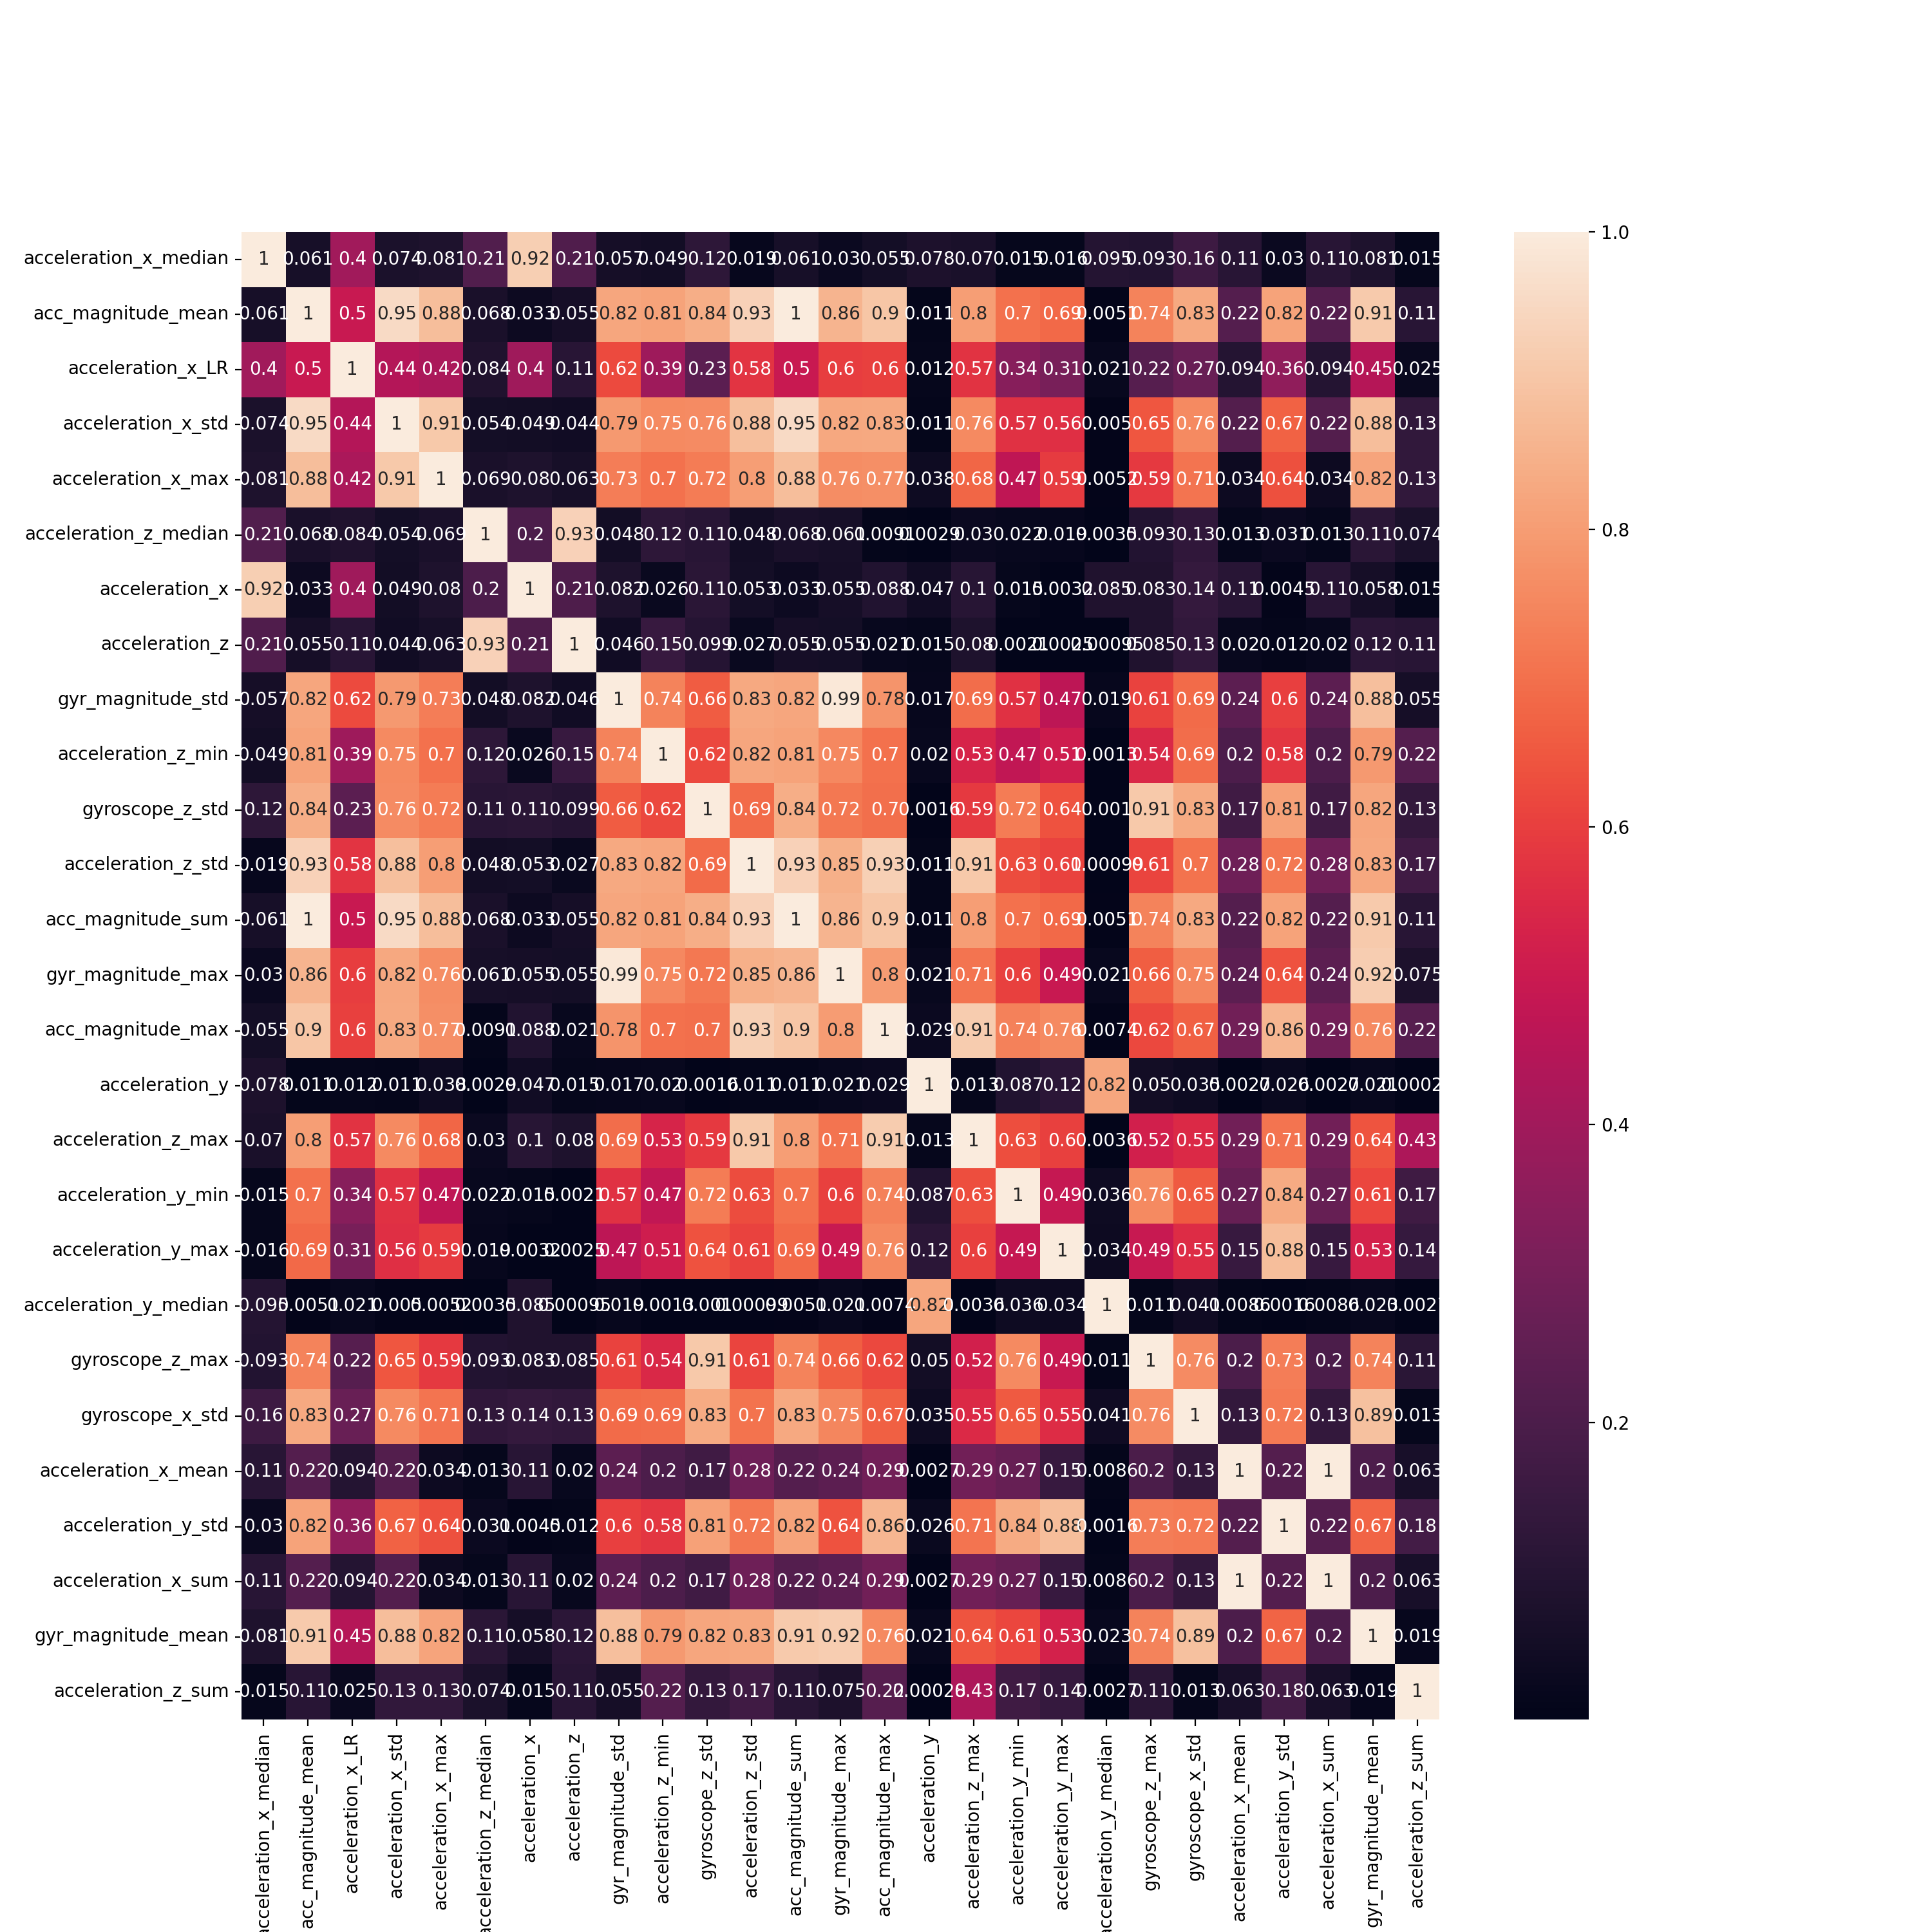

Dropped Feature Are: 

['acceleration_x_std', 'acceleration_x_max', 'acceleration_x', 'acceleration_z', 'acceleration_z_std', 'acc_magnitude_sum', 'gyr_magnitude_max', 'acc_magnitude_max', 'acceleration_z_max', 'gyroscope_z_max', 'acceleration_x_sum', 'gyr_magnitude_mean']

Selected Features Are: 

Index(['acceleration_x_median', 'acc_magnitude_mean', 'acceleration_x_LR',
       'acceleration_z_median', 'gyr_magnitude_std', 'acceleration_z_min',
       'gyroscope_z_std', 'acceleration_y', 'acceleration_y_min',
       'acceleration_y_max', 'acceleration_y_median', 'gyroscope_x_std',
       'acceleration_x_mean', 'acceleration_y_std', 'acceleration_z_sum'],
      dtype='object')


In [13]:
import seaborn as sns

selected_feature = list(sorted_list1)[0:df_imp[df_imp['CUMSUM']>0.9].index[0]]
hm = X[selected_feature]

plt.figure(figsize=(15,15))
sns.heatmap(hm.corr().abs(), annot=True)
plt.show()

# Create correlation matrix
corr_matrix = hm.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print('Dropped Feature Are: \n')
print(to_drop)

# Select only important features
X_selected = X[selected_feature].drop(to_drop, axis=1)
feature_select = X_selected.columns

print('\nSelected Features Are: \n')
print(feature_select)


# 2. Model Training

### Model Training - Linear regresion (single feature)

In [32]:
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.linear_model import LogisticRegression

data = dataset_feat.dropna()
data = data[data["simple_label"].isin(["falling", "walking", "standing","laying"])]

v=[]
w=[]
nwin = 11
nwin_half = int(np.floor(nwin/2))
for f in data.filename.unique():
    data_ind = data.loc[lambda df: df['filename']==f, :]
    X = data_ind.drop(['label','simple_label','filename'], axis=1)
    y = data_ind['simple_label']

    X_feat = X['acceleration_x'] #acc_magnitude_mean, acceleration_x_median
    # print(X_acc_x_median.shape)

    v_temp = sliding_window_view(X_feat, nwin)
    # print(v.shape)

    w_temp = y[nwin_half:-nwin_half]
    w_temp = (w_temp=='falling')*1

    v.append(v_temp)
    w.append(w_temp)

v = np.concatenate(v, axis=0)
w = np.concatenate(w, axis=0)

# Logistic regression
X_train, X_test, y_train, y_test = train_test_split(v, w, test_size=0.2, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(f'Number of Train Data: {X_train.shape}')
print(f'Number of Train Label:{ y_train.shape}')

Number of Train Data: (19965, 11)
Number of Train Label:(19965,)


In [33]:
# Initialize the model you want to use
classifier_LR = LogisticRegression(max_iter=200, random_state = 42)

# Fit the model on the training set
classifier_LR.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier_LR.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# coeff & intercept
print(f"coefficient : {classifier_LR.coef_}")
print(f"intercept: {classifier_LR.intercept_}")
r_sq = classifier_LR.score(X_train, y_train)
print(f"R square: {r_sq}")

Accuracy: 0.9609375

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4756
           1       0.90      0.19      0.32       236

    accuracy                           0.96      4992
   macro avg       0.93      0.60      0.65      4992
weighted avg       0.96      0.96      0.95      4992

coefficient : [[ 0.93728429  0.21087042  0.19920865  0.03399737 -0.09725168  0.00803635
  -0.18278399 -0.08111115 -0.35532985 -0.39608961 -1.24655141]]
intercept: [-3.69660231]
R square: 0.9621838216879539


### save model - LR


In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "./model/LR_acceleration_x/LR_classifier_model.pkl"  
scaler_pkl_file = "./model/LR_acceleration_x/LR_scaler.pkl"  

with open(model_pkl_file, 'wb') as model_file:  
    pickle.dump(classifier_LR, model_file)

with open(scaler_pkl_file,'wb') as sc_file:
    pickle.dump(sc, sc_file)

### Model Training (cv) - Random forest

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def calculate_mean_metrics(list_classification_reports):
    # Initialize dictionaries to store the sum of metrics for each label
    falling_sum = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
    laying_sum = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
    standing_sum = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
    walking_sum = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
    accuracy_sum = []

    # Iterate over each dictionary and update the sums
    for entry in list_classification_reports:
        for label in ['precision', 'recall', 'f1-score', 'support']:
            falling_sum[label].append(entry['falling'][label])
            laying_sum[label].append(entry['laying'][label])
            standing_sum[label].append(entry['standing'][label])
            walking_sum[label].append(entry['walking'][label])

        accuracy_sum.append(entry['accuracy'])

    # Calculate means
    falling_mean = {label: round(np.mean(falling_sum[label]),2) for label in falling_sum}
    laying_mean = {label: round(np.mean(laying_sum[label]),2) for label in laying_sum}
    standing_mean = {label: round(np.mean(standing_sum[label]),2) for label in standing_sum}
    walking_mean = {label: round(np.mean(walking_sum[label]),2) for label in walking_sum}
    accuracy_mean = round(np.mean(accuracy_sum),3)

    # Combine mean metrics into a single dictionary
    mean_metrics = {
        'falling': falling_mean,
        'laying': laying_mean,
        'standing': standing_mean,
        'walking': walking_mean,
        'Accuracy': accuracy_mean
    }

    print("Falling:", falling_mean)
    print("Laying:", laying_mean)
    print("Standing:", standing_mean)
    print("Walking:", walking_mean)
    print("Accuracy:", accuracy_mean)

    return mean_metrics


# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [5, 10, 15, 20],  
    'max_depth': [5, 10, 15, 20],
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_selected, y)

# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 20, 'n_estimators': 20}
Best Score: 0.9721640568203427


In [15]:
# Initialize the Random Forest classifier
classifier = RandomForestClassifier(n_estimators=20, max_depth=10, class_weight='balanced', random_state=42)
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Train data with 10-folds cross validation
list_classification_reports = []
for train_index, test_index in k_fold.split(X_selected, y):
    X_train, X_test = X_selected.iloc[train_index,:], X_selected.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)

    # Train the classifier
    classifier.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred = classifier.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    list_classification_reports.append(report)

# Calculate mean classification report
_ = calculate_mean_metrics(list_classification_reports)


Falling: {'precision': 0.91, 'recall': 0.9, 'f1-score': 0.9, 'support': 113.9}
Laying: {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99, 'support': 484.6}
Standing: {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99, 'support': 1168.5}
Walking: {'precision': 0.99, 'recall': 1.0, 'f1-score': 1.0, 'support': 747.7}
Accuracy: 0.989


In [16]:
# Train-Test split
X_train = X_selected
y_train = y

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

# Train Random Forest classifier on selected features
classifier.fit(X_train, y_train)

#report
print('Train set')
classification_report_str = classification_report(y_train, classifier.predict(X_train))
print(classification_report_str)


Train set
              precision    recall  f1-score   support

     falling       0.96      0.99      0.98      1139
      laying       1.00      1.00      1.00      4846
    standing       1.00      0.99      1.00     11685
     walking       1.00      1.00      1.00      7477

    accuracy                           1.00     25147
   macro avg       0.99      1.00      0.99     25147
weighted avg       1.00      1.00      1.00     25147



### Plot random forest

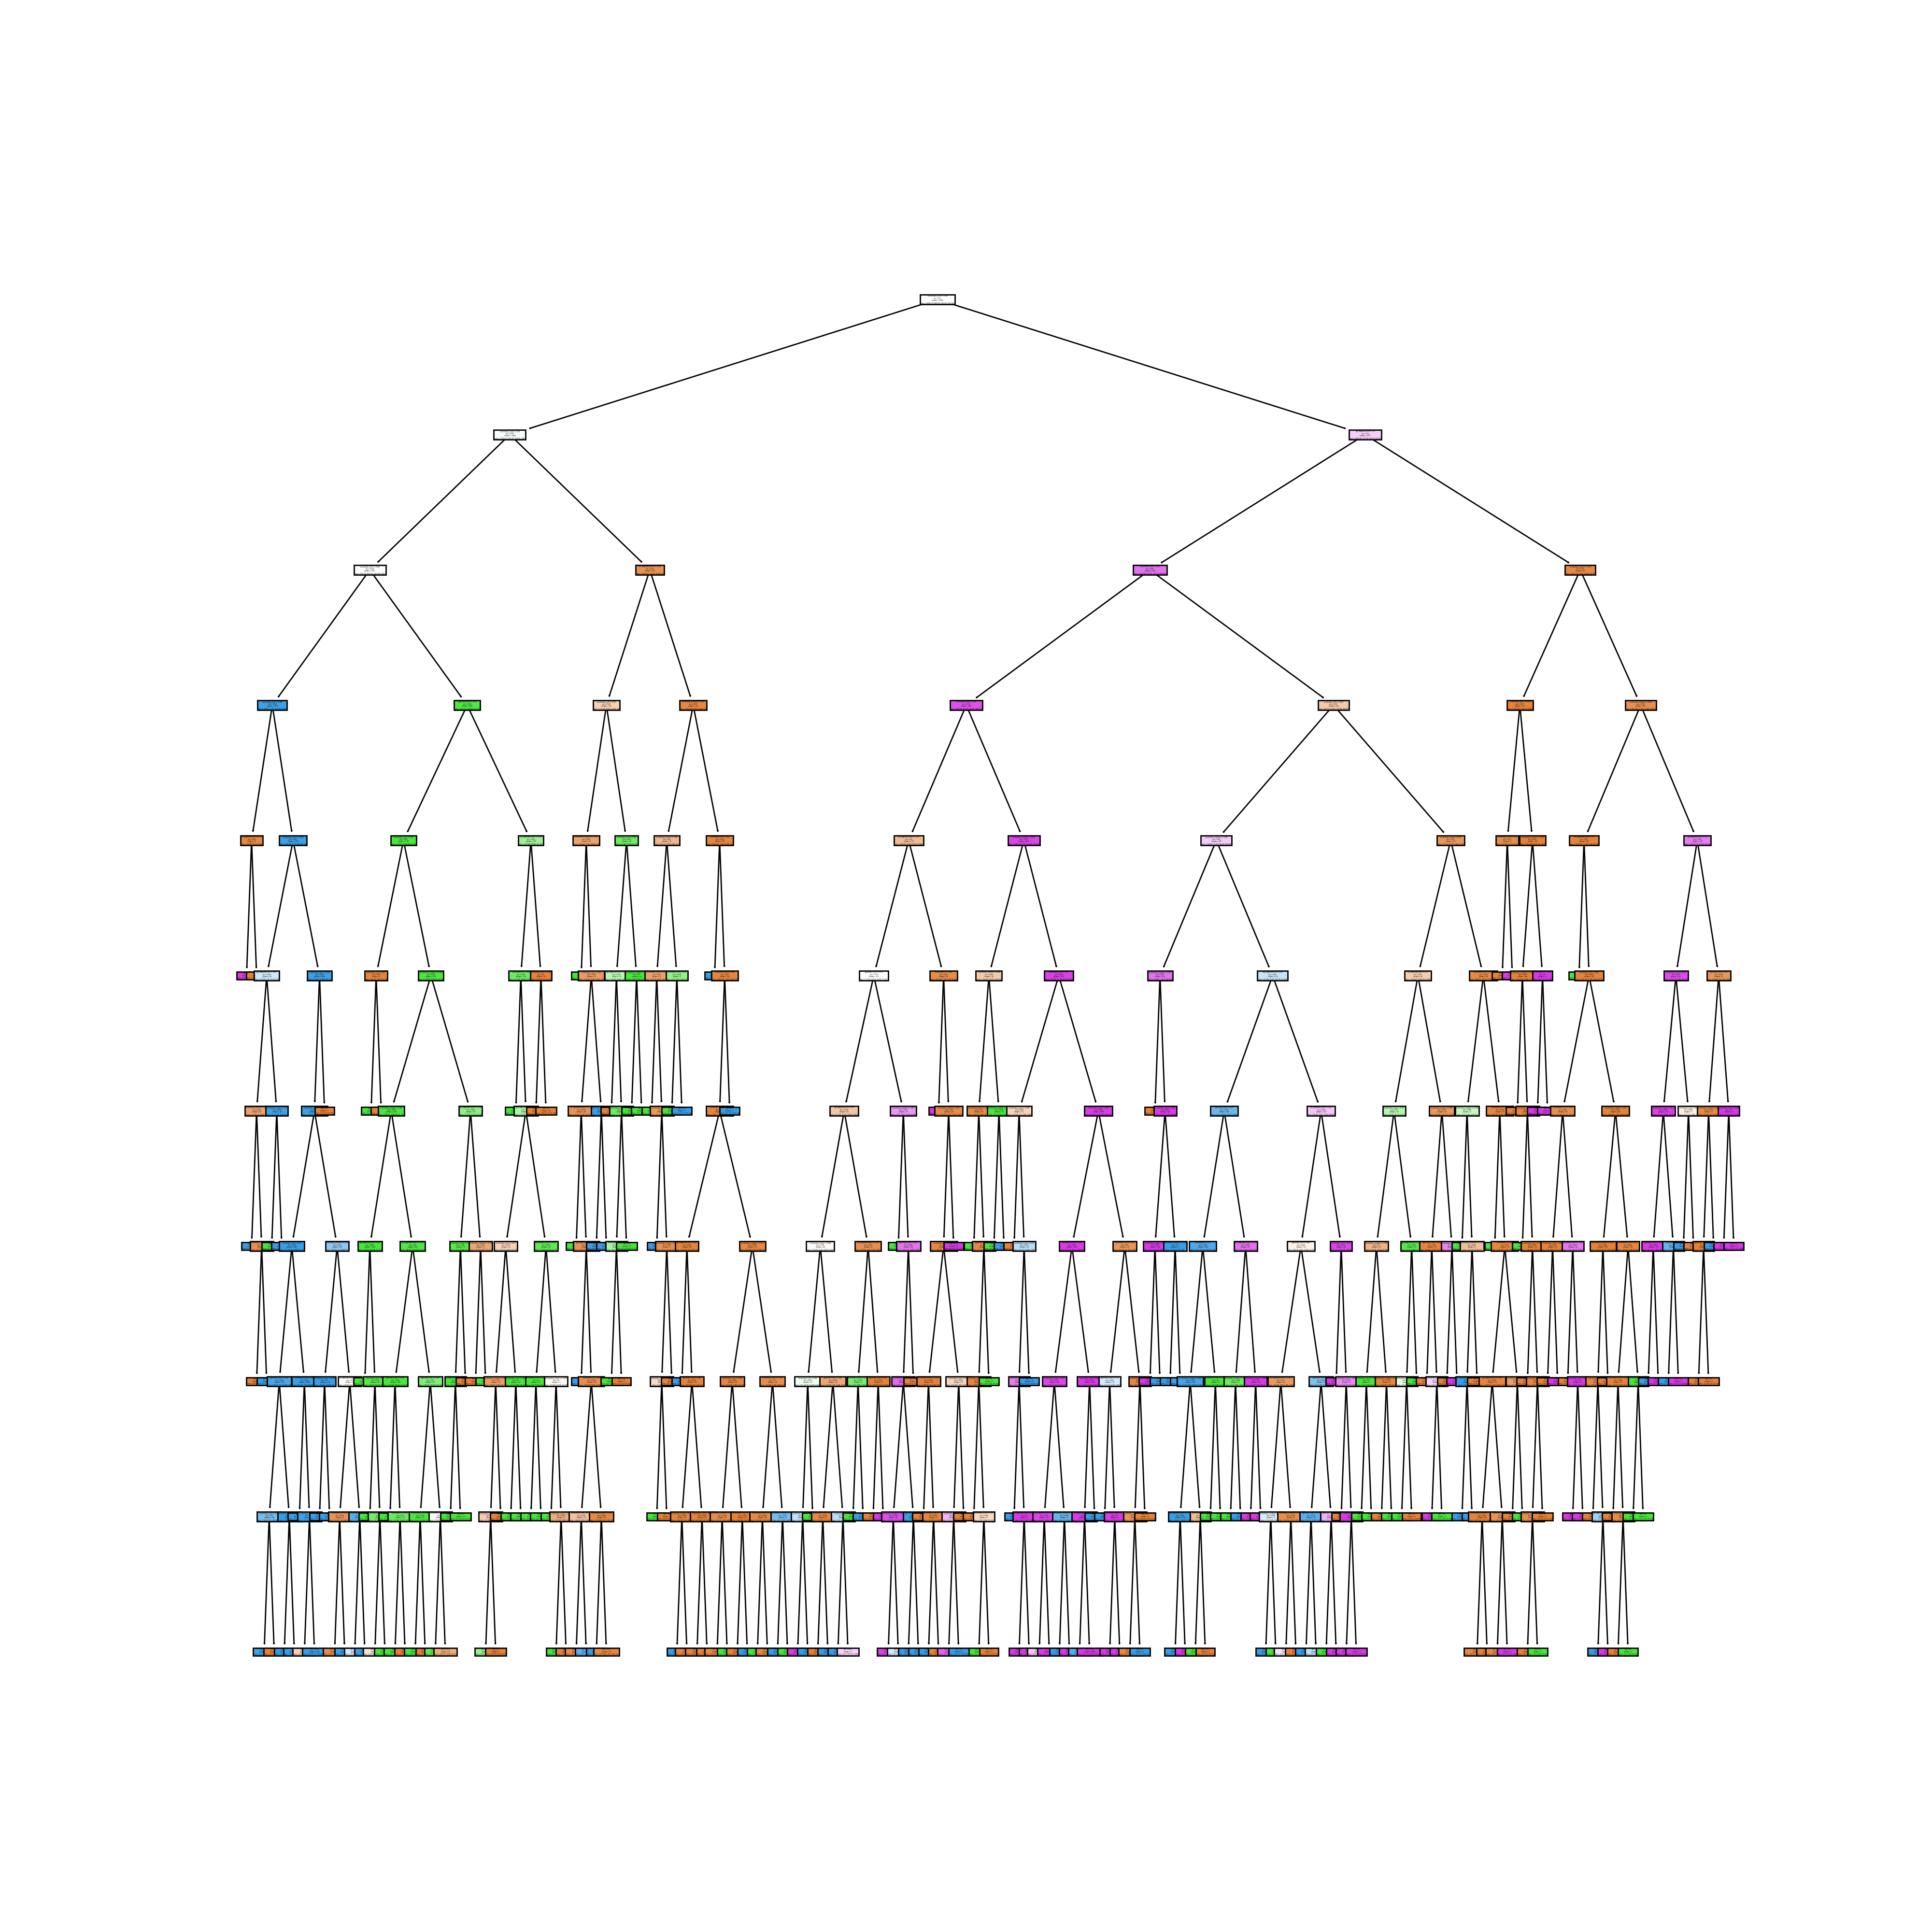

In [17]:
from sklearn import tree
plt.figure(figsize=(20,20))
_ = tree.plot_tree(classifier.estimators_[0], feature_names=X_selected.columns, filled=True)
plt.show()

### Save model - RF

In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "./model/RandomForest_3/RF_classifier_model.pkl"  
scaler_pkl_file = "./model/RandomForest_3/scaler.pkl"  

with open(model_pkl_file, 'wb') as model_file:  
    pickle.dump(classifier, model_file)

with open(scaler_pkl_file,'wb') as sc_file:
    pickle.dump(sc, sc_file)

## Visualize Prediction

d:\OneDrive - Chalmers\Git\een210_applied_digital_health\.venv\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 380 rows containing missing values.


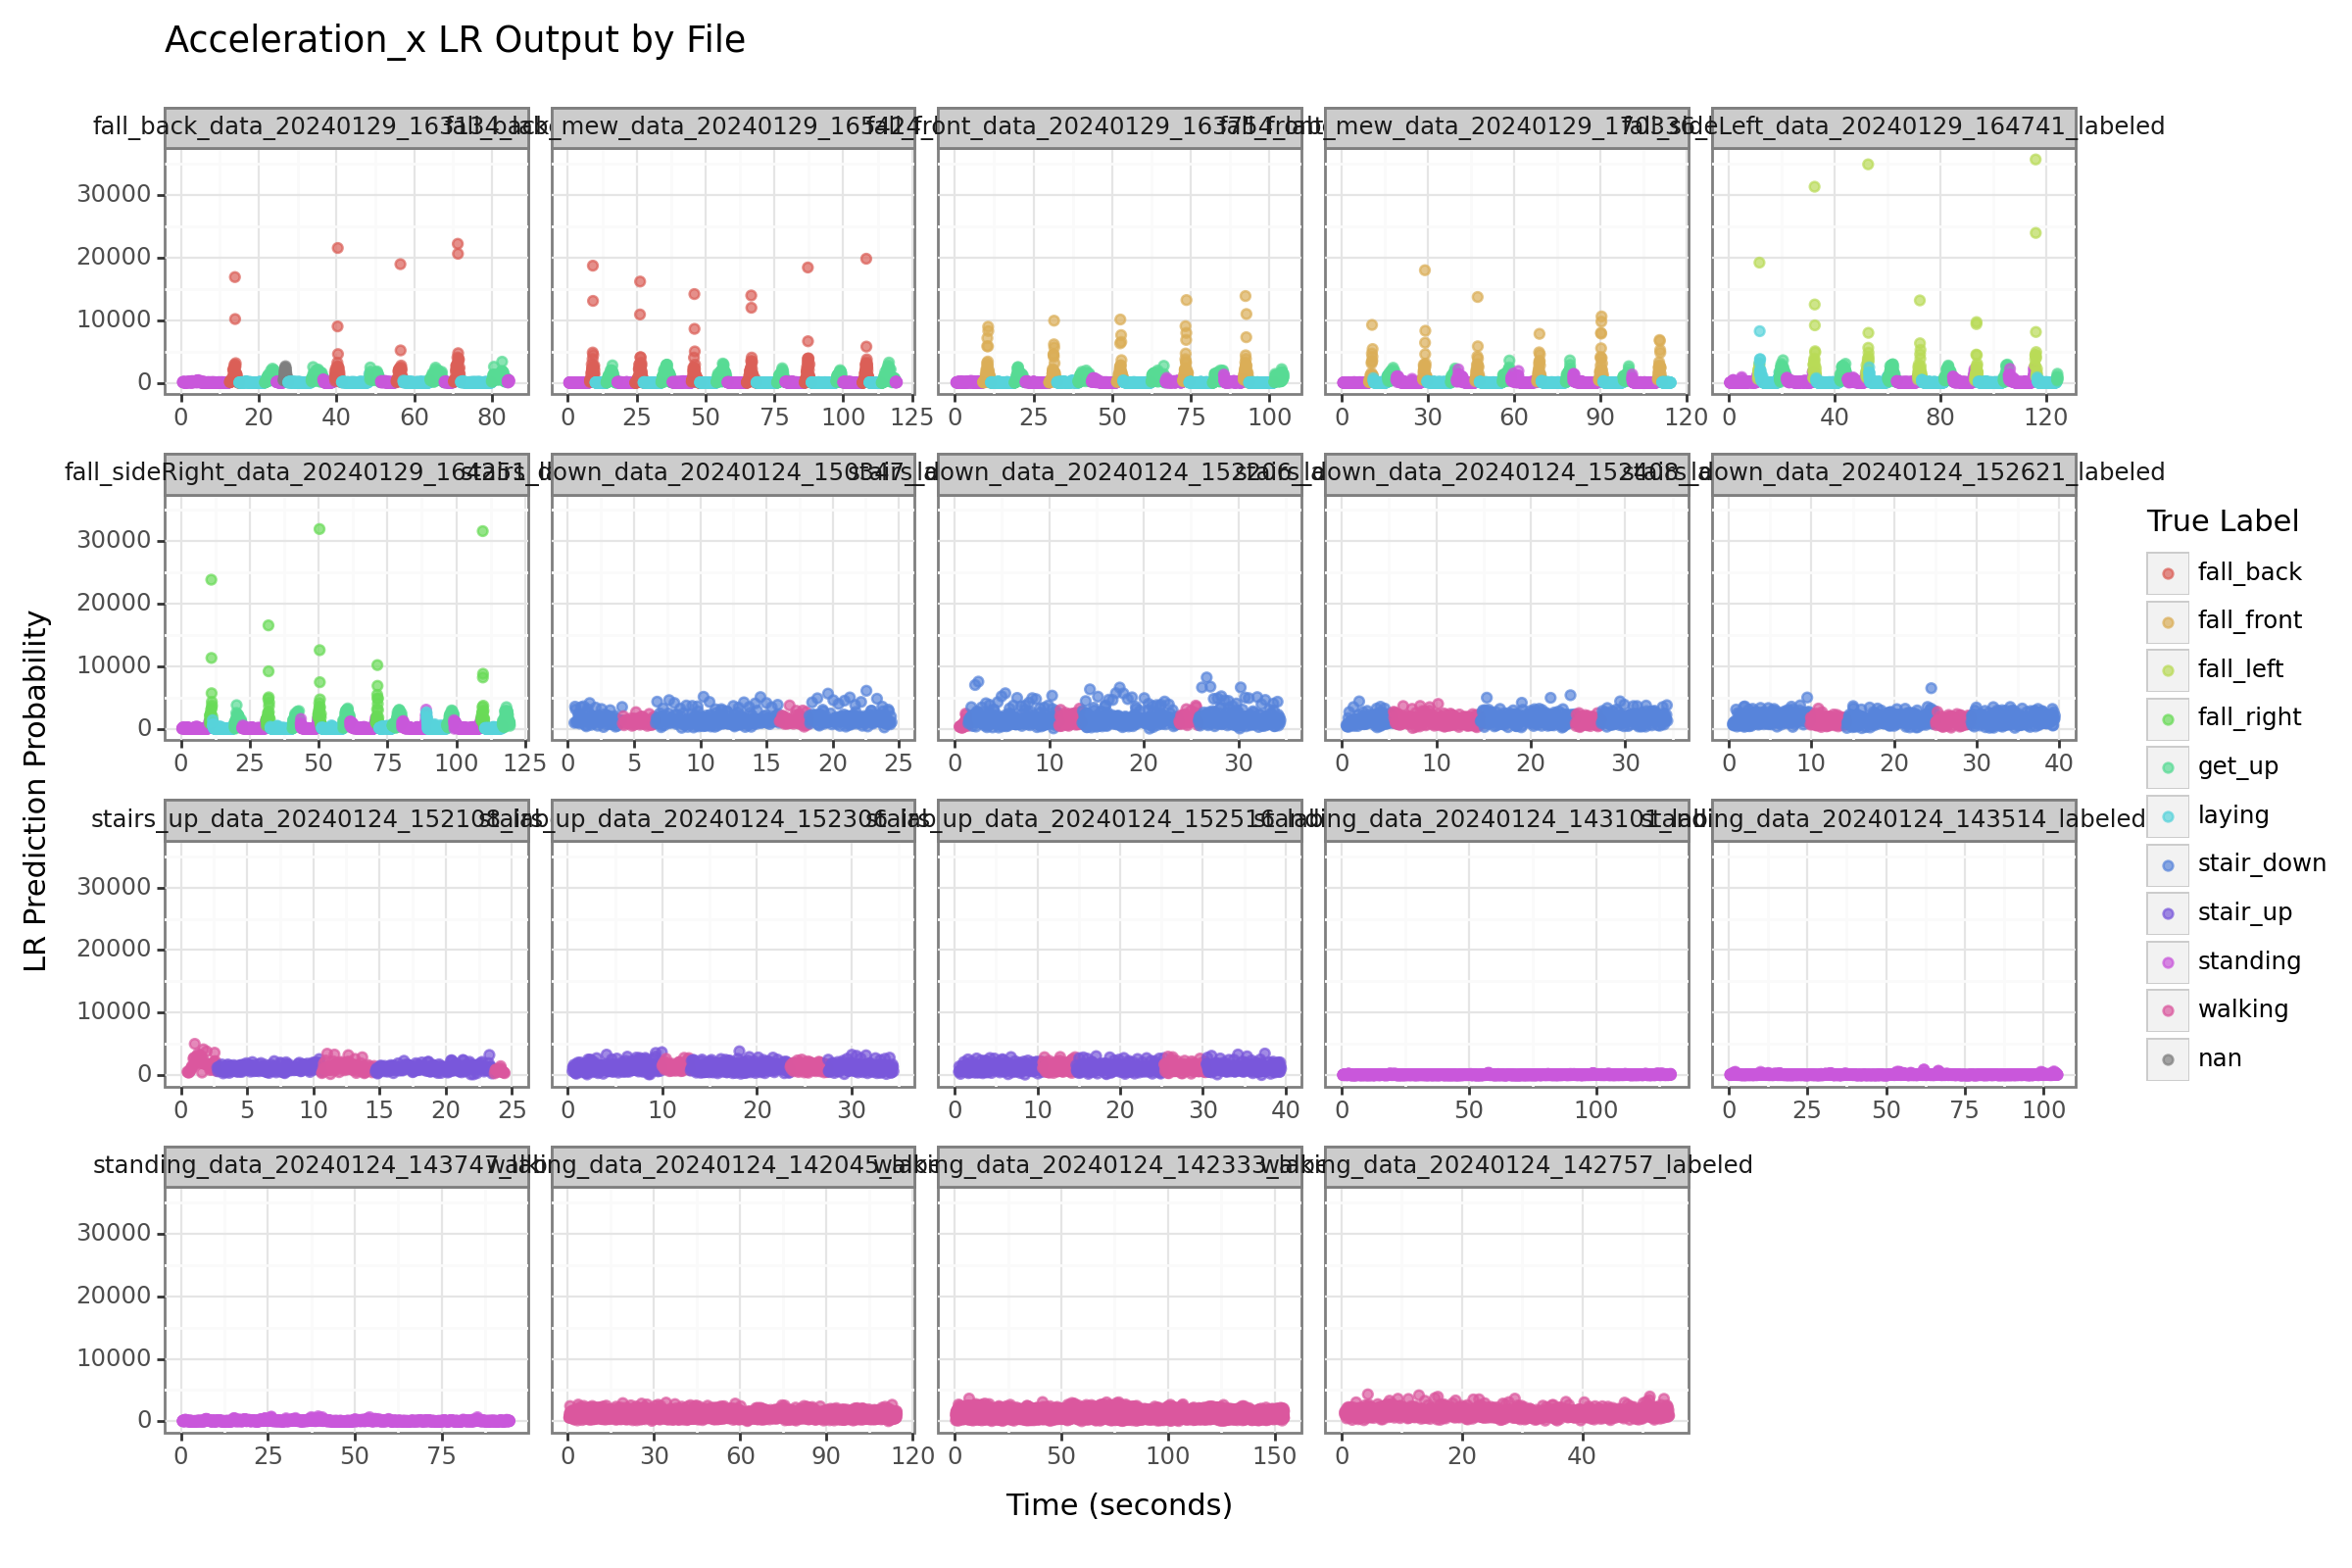

In [28]:
data_for_plot = dataset_feat.copy()
data_for_plot['time_index'] = data_for_plot.groupby('filename').cumcount() / 20

p = (
    ggplot(data_for_plot, aes(x='time_index', y='acc_magnitude', color='label'))
    + geom_point(alpha=0.7)
    + facet_wrap('~filename', scales='free_x') # Create a separate plot for each file
    + labs(
        title='Acceleration_x LR Output by File',
        x='Time (seconds)',
        y='LR Prediction Probability',
        color='True Label'
    )
    + theme_bw() # A clean, professional theme
    # Adjust plot size for better viewing, especially with many facets
    + theme(figure_size=(12, 8)) 
)

# Print the single, complete plot
print(p)

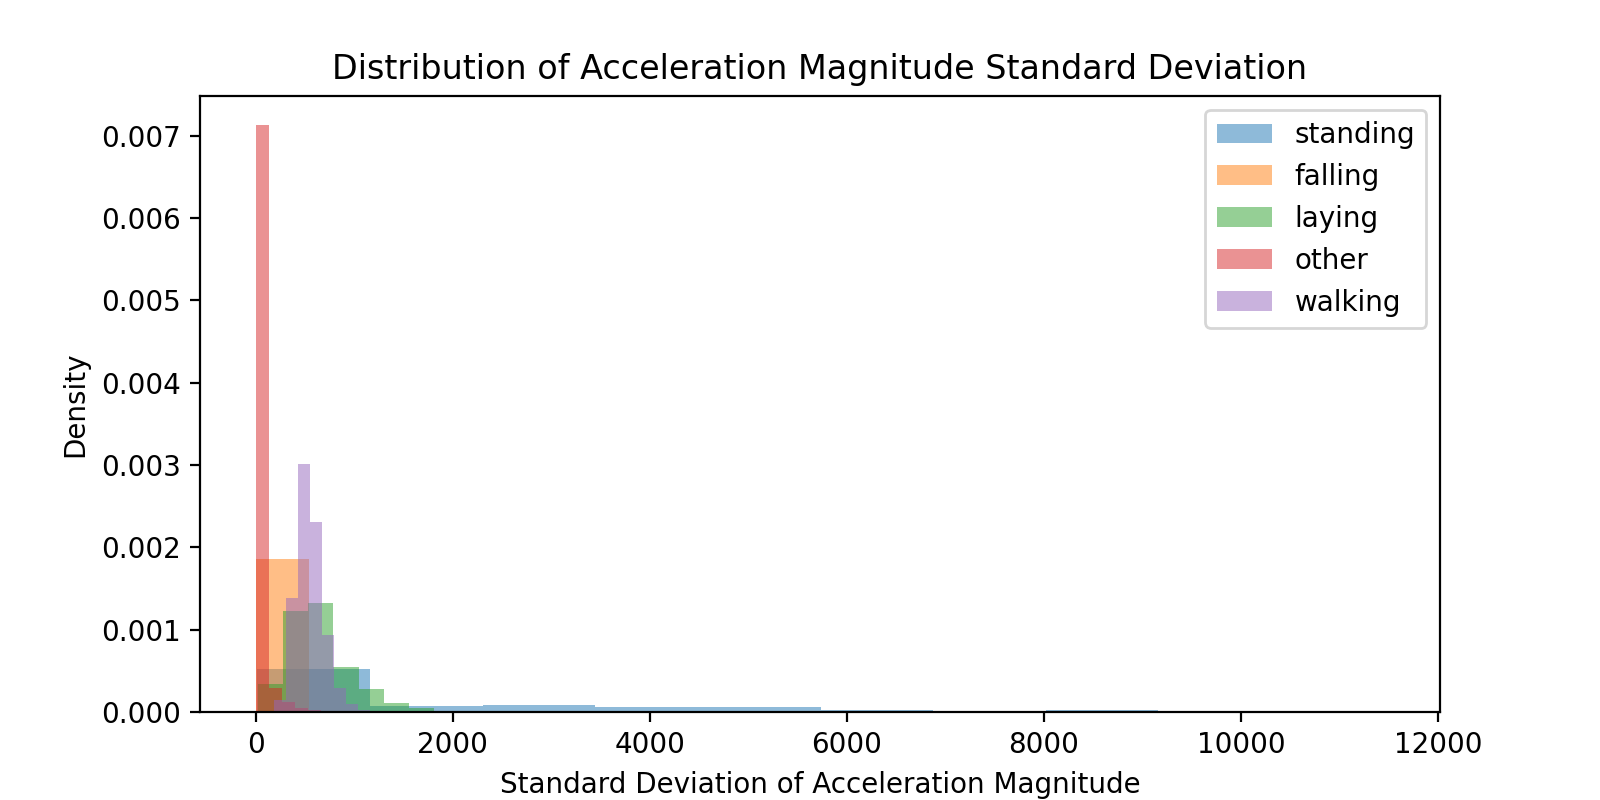

In [24]:
# Plot distribution of points 
plt.figure(figsize=(8,4))
dataset_feat.groupby('simple_label')['acc_magnitude_std'].plot(kind='hist', alpha=0.5, density=True)
plt.title('Distribution of Acceleration Magnitude Standard Deviation')
plt.xlabel('Standard Deviation of Acceleration Magnitude')
plt.ylabel('Density')
plt.legend(dataset_feat['simple_label'].unique(), loc='upper right') # Use simple_label for the legend
plt.show()